In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set2")

import warnings
warnings.filterwarnings("ignore")

from classifier_utils import *
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# Load data
df = pd.read_csv("../../Hanoi-Housing-Prices-Prediction/Feature engineering/remaining_chungcu.csv")
df_columns = df.columns.tolist() 
print("+ Shape: ", df.shape) # (Number of Lines, Number of Columns)
print("+ Column: ", df_columns) # Name the attribute columns.
df.info()

+ Shape:  (12274, 29)
+ Column:  ['Dự án', 'Đường/Phố', 'Phường/Xã', 'Quận/Huyện', 'Phân loại quận', 'Loại tin', 'Mã tin', 'Diện tích', 'Mức giá', 'Hướng nhà', 'Hướng ban công', 'Số phòng ngủ', 'Số toilet', 'Pháp lý', 'Nội thất', 'Loại hình chung cư', 'Nhóm 1-Trường học', 'Nhóm 1-Chợ/Siêu thị', 'Nhóm 1-Bệnh viện', 'Nhóm 2-Công viên', 'Nhóm 2-Bể bơi', 'Nhóm 2-Gym', 'Slot ô tô', 'Nhà thoáng', 'Hiện đại', 'Bán gấp', 'Lô góc', 'Hỗ trợ vay', 'Tầng']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12274 entries, 0 to 12273
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Dự án                12274 non-null  object 
 1   Đường/Phố            9465 non-null   object 
 2   Phường/Xã            12132 non-null  object 
 3   Quận/Huyện           12274 non-null  object 
 4   Phân loại quận       12274 non-null  object 
 5   Loại tin             12274 non-null  object 
 6   Mã tin               12274 non-null  

In [3]:
df

,Dự án,Đường/Phố,Phường/Xã,Quận/Huyện,Phân loại quận,Loại tin,Mã tin,Diện tích,Mức giá,Hướng nhà,...,Nhóm 2-Công viên,Nhóm 2-Bể bơi,Nhóm 2-Gym,Slot ô tô,Nhà thoáng,Hiện đại,Bán gấp,Lô góc,Hỗ trợ vay,Tầng
0,Golden Palace,Mễ Trì,Mễ Trì,Nam Từ Liêm,Nội thành,Tin thường,37587338,128.0,35.0,Tây - Bắc,...,0,0,0,1,1,0,0,0,1,Trung
1,CT5 Văn Khê,NaN,La Khê,Hà Đông,Nội thành,Tin thường,39014297,82.0,32.3,Tây - Bắc,...,0,0,0,0,0,0,0,0,0,NaN
2,Diamond Flower Tower,Hoàng Đạo Thúy,Nhân Chính,Thanh Xuân,Nội thành,Tin thường,39135117,115.0,55.0,Nam,...,0,0,0,1,1,1,1,0,0,NaN
3,Sun Grand City,Thụy Khuê,Thụy Khuê,Tây Hồ,Nội thành,Tin thường,37509440,250.0,96.0,NaN,...,1,1,1,0,1,1,0,0,0,NaN
4,Vinhomes West Point,Phạm Hùng,Mễ Trì,Nam Từ Liêm,Nội thành,Tin thường,39159735,93.0,69.9,Tây - Bắc,...,0,0,0,0,0,0,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12269,FLC Complex Phạm Hùng,Phạm Hùng,Mỹ Đình 2,Nam Từ Liêm,Nội thành,Tin thường,39167039,131.0,35.0,Tây - Nam,...,0,0,0,0,1,0,0,1,0,NaN
12270,HC Golden City,NaN,Bồ Đề,Long Biên,Nội thành,Tin thường,39205745,102.3,47.9,NaN,...,0,0,1,0,1,1,0,0,0,NaN
12271,Vinhomes D'Capitale,Trần Duy Hưng,Trung Hòa,Cầu Giấy,Nội thành,Tin thường,39183034,73.0,68.5,Tây - Bắc,...,0,0,0,0,0,0,0,0,0,NaN
12272,Times City,Minh Khai,Vĩnh Tuy,Hai Bà Trưng,Nội thành,Tin thường,36361390,83.0,55.4,Nam,...,0,0,0,0,0,0,0,0,0,NaN


In [4]:
df.isnull().sum()/df.shape[0] * 100.00

Dự án                   0.000000
Đường/Phố              22.885775
Phường/Xã               1.156917
Quận/Huyện              0.000000
Phân loại quận          0.000000
Loại tin                0.000000
Mã tin                  0.000000
Diện tích               0.000000
Mức giá                 0.000000
Hướng nhà              49.845201
Hướng ban công         45.665635
Số phòng ngủ            2.656021
Số toilet               7.324426
Pháp lý                 0.000000
Nội thất                0.000000
Loại hình chung cư      0.000000
Nhóm 1-Trường học       0.000000
Nhóm 1-Chợ/Siêu thị     0.000000
Nhóm 1-Bệnh viện        0.000000
Nhóm 2-Công viên        0.000000
Nhóm 2-Bể bơi           0.000000
Nhóm 2-Gym              0.000000
Slot ô tô               0.000000
Nhà thoáng              0.000000
Hiện đại                0.000000
Bán gấp                 0.000000
Lô góc                  0.000000
Hỗ trợ vay              0.000000
Tầng                   76.975721
dtype: float64

In [5]:
columns_to_drop = ['Loại tin', 'Mã tin', 'Hướng nhà', 'Hướng ban công', 'Nội thất', 'Tầng']
df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12274 entries, 0 to 12273
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Dự án                12274 non-null  object 
 1   Đường/Phố            9465 non-null   object 
 2   Phường/Xã            12132 non-null  object 
 3   Quận/Huyện           12274 non-null  object 
 4   Phân loại quận       12274 non-null  object 
 5   Diện tích            12274 non-null  float64
 6   Mức giá              12274 non-null  float64
 7   Số phòng ngủ         11948 non-null  float64
 8   Số toilet            11375 non-null  float64
 9   Pháp lý              12274 non-null  object 
 10  Loại hình chung cư   12274 non-null  object 
 11  Nhóm 1-Trường học    12274 non-null  int64  
 12  Nhóm 1-Chợ/Siêu thị  12274 non-null  int64  
 13  Nhóm 1-Bệnh viện     12274 non-null  int64  
 14  Nhóm 2-Công viên     12274 non-null  int64  
 15  Nhóm 2-Bể bơi        12274 non-null 

In [6]:
# Fill NaN
df['Phường/Xã'].fillna(df['Phường/Xã'].mode()[0], inplace=True)
df['Đường/Phố'].fillna(df['Đường/Phố'].mode()[0], inplace=True)

numeric_cols = ['Diện tích', 'Số phòng ngủ', 'Số toilet']
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)

phuongloai_mapping = {'Nội thành': 1, 'Ngoại thành': 0}
df['Phân loại quận'] = df['Phân loại quận'].map(phuongloai_mapping)

# One-Hot Encoding 
onehot_encoder = OneHotEncoder()
onehot_encoded = onehot_encoder.fit_transform(df[['Quận/Huyện']]).toarray()
onehot_encoded_df = pd.DataFrame(onehot_encoded, 
                                 columns=onehot_encoder.get_feature_names_out(['Quận/Huyện']), 
                                 dtype=bool)
onehot_encoded_df = onehot_encoded_df * 1

onehot_encoder_phap_ly = OneHotEncoder()
phap_ly_encoded = onehot_encoder_phap_ly.fit_transform(df[['Pháp lý']]).toarray()
phap_ly_encoded_df = pd.DataFrame(phap_ly_encoded, 
                                  columns=onehot_encoder_phap_ly.get_feature_names_out(['Pháp lý']), 
                                  dtype=bool)
phap_ly_encoded_df = phap_ly_encoded_df * 1

onehot_encoder_loai_hinh_cc = OneHotEncoder()
loai_hinh_cc_encoded = onehot_encoder_loai_hinh_cc.fit_transform(df[['Loại hình chung cư']]).toarray()
loai_hinh_cc_encoded_df = pd.DataFrame(loai_hinh_cc_encoded, 
                                        columns=onehot_encoder_loai_hinh_cc.get_feature_names_out(['Loại hình chung cư']), 
                                        dtype=bool)
loai_hinh_cc_encoded_df = loai_hinh_cc_encoded_df * 1

df = pd.concat([df, onehot_encoded_df], axis=1)
df.drop(columns=['Quận/Huyện'], inplace=True)

df = pd.concat([df, phap_ly_encoded_df], axis=1)
df.drop(columns=['Pháp lý'], inplace=True)

df = pd.concat([df, loai_hinh_cc_encoded_df], axis=1)
df.drop(columns=['Loại hình chung cư'], inplace=True)

# Label Encoding 
label_encoder_px = LabelEncoder()
df['Phường/Xã'] = label_encoder_px.fit_transform(df['Phường/Xã'].str.replace("Phường ", ""))
df['Đường/Phố'] = label_encoder_px.fit_transform(df['Đường/Phố'].str.replace("Đường ", ""))
df['Dự án'] = label_encoder_px.fit_transform(df['Dự án'])

print(df)

       Dự án  Đường/Phố  Phường/Xã  Phân loại quận  Diện tích  Mức giá  \
0        414        206         63               1      128.0     35.0   
1         79        371         48               1       82.0     32.3   
2        363        137         80               1      115.0     55.0   
3        817        324        126               1      250.0     96.0   
4        955        289         63               1       93.0     69.9   
...      ...        ...        ...             ...        ...      ...   
12269    392        289         66               1      131.0     35.0   
12270    429        371          7               1      102.3     47.9   
12271    944        340        128               1       73.0     68.5   
12272    897        202        151               1       83.0     55.4   
12273    827        371         89               1      100.0     55.0   

       Số phòng ngủ  Số toilet  Nhóm 1-Trường học  Nhóm 1-Chợ/Siêu thị  ...  \
0               3.0        2.0  

In [7]:
df.isnull().sum()/df.shape[0] * 100.00

Dự án                                     0.0
Đường/Phố                                 0.0
Phường/Xã                                 0.0
Phân loại quận                            0.0
Diện tích                                 0.0
Mức giá                                   0.0
Số phòng ngủ                              0.0
Số toilet                                 0.0
Nhóm 1-Trường học                         0.0
Nhóm 1-Chợ/Siêu thị                       0.0
Nhóm 1-Bệnh viện                          0.0
Nhóm 2-Công viên                          0.0
Nhóm 2-Bể bơi                             0.0
Nhóm 2-Gym                                0.0
Slot ô tô                                 0.0
Nhà thoáng                                0.0
Hiện đại                                  0.0
Bán gấp                                   0.0
Lô góc                                    0.0
Hỗ trợ vay                                0.0
Quận/Huyện_Ba Đình                        0.0
Quận/Huyện_Bắc Từ Liêm            

In [8]:
df

,Dự án,Đường/Phố,Phường/Xã,Phân loại quận,Diện tích,Mức giá,Số phòng ngủ,Số toilet,Nhóm 1-Trường học,Nhóm 1-Chợ/Siêu thị,...,Quận/Huyện_Đống Đa,Pháp lý_Hợp đồng mua bán,Pháp lý_Khác,Pháp lý_Sổ chung,"Pháp lý_Sổ đỏ, sổ hồng, pháp lý đầy đủ",Pháp lý_Vi bằng,Pháp lý_Đang chờ sổ,Loại hình chung cư_Chung cư,Loại hình chung cư_Chung cư mini,Loại hình chung cư_Nhà tập thể
0,414,206,63,1,128.0,35.0,3.0,2.0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,79,371,48,1,82.0,32.3,2.0,2.0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,363,137,80,1,115.0,55.0,3.0,2.0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,817,324,126,1,250.0,96.0,4.0,3.0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,955,289,63,1,93.0,69.9,3.0,2.0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12269,392,289,66,1,131.0,35.0,3.0,3.0,0,0,...,0,0,0,0,1,0,0,1,0,0
12270,429,371,7,1,102.3,47.9,3.0,2.0,0,0,...,0,0,1,0,0,0,0,1,0,0
12271,944,340,128,1,73.0,68.5,2.0,2.0,0,0,...,0,0,0,0,1,0,0,1,0,0
12272,897,202,151,1,83.0,55.4,2.0,2.0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [9]:
# Split data into features and target variable
X_train, y_train, X_test, y_test = divide_dataset(df, target='Mức giá')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11046, 48) (11046,) (1228, 48) (1228,)


**Basic Models:**
1. Linear Regression
- Linear Regression is a statistical method for modeling the relationship between a dependent variable with a continuous value and independent variables, which can have either continuous or categorical values. In other words, "Linear Regression" is a method to predict the dependent variable (Y) based on the values of independent variables (X).
- The Linear Regression model seeks the best-fitting linear line to model the relationship between the dependent variable and independent variables. The parameters of the model are found through optimization methods, aiming to minimize the error between predictions and actual values. The result is a simple, understandable, and easy-to-use model, providing the ability to predict new values based on known input variables.

2. Decision Tree
- A Decision Tree is a machine learning method used in both regression and classification problems. It operates by dividing the data into smaller parts and guiding each decision based on the features of the data. Each node in the tree represents a decision based on a feature, and the branches of the node represent the outcomes of the decision. This process continues until predefined stopping conditions are met, such as a minimum number of samples in each leaf or maximum tree depth.

3. Random Forest
- Random Forest is an Ensemble Learning technique, where a series of decision trees are constructed by enhancing Bootstrapping and Bagging techniques.
- Bootstrapping is a statistical technique generating B new datasets from an original dataset of size N, with samples drawn randomly from the dataset, allowing for resampling and potentially repeated instances.
- Bagging fits models on datasets drawn using Bootstrapping technique and averages the prediction results of those models to obtain a new model with lower variance.
- Bagging is an effective Ensemble Learning technique as each decision tree is fitted with a slightly different training set, leading to slightly different results. Unlike conventional decision tree models, such as Classification and Regression Trees (CART), they often overfit the training dataset. Bagging helps to diversify each tree, reducing variance and prediction errors.
- Unlike Bagging, Random Forest samples not only observations in the dataset but also samples over all features and randomly selects a subset to construct the decision tree. Sampling over features helps each tree not to use the same amount of information to make decisions, thus reducing the correlation among different trees.

4. Gradient Boosting
- Gradient Boosting is a popular and powerful machine learning algorithm for handling tabular datasets. It effectively captures nonlinear relationships between the target variable and input variables.
- In Gradient Boosting, we build a sequence of weak decision trees, called base learners. Each base learner is built based on adjusting the prediction errors of the previous tree. This process is done by optimizing the loss function, adjusting the weights of the base learners to minimize the prediction errors.
- Gradient Boosting algorithm uses gradient descent optimization method to adjust the weights of the base learners. This method searches for the best descent direction of the loss function in the weight space. This process iterates repeatedly, with each iteration creating a new base learner and updating their weights.
- One of the strengths of Gradient Boosting is its ability to handle complex tabular data without requiring special preprocessing. It can work with numerical and categorical variables, while handling missing values and outliers. Additionally, Gradient Boosting is resistant to overfitting and builds accurate prediction models.

Training Linear Regression...


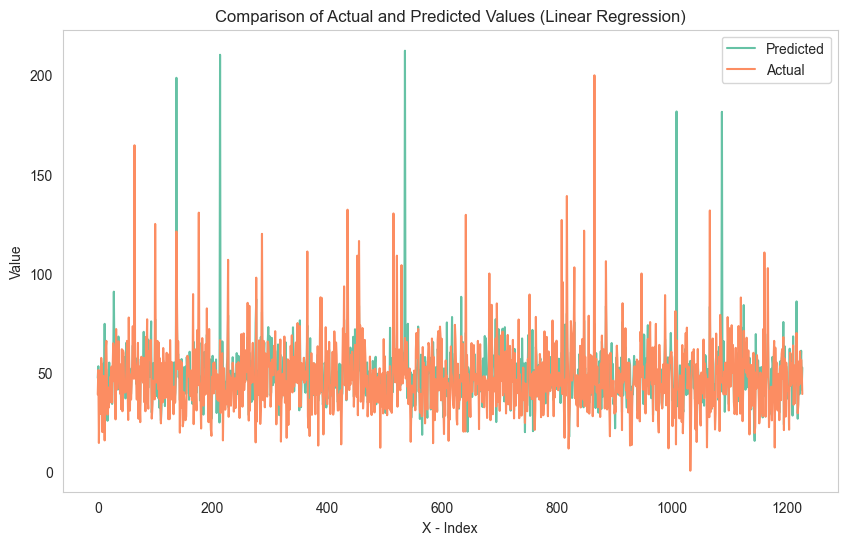

Training Decision Tree...


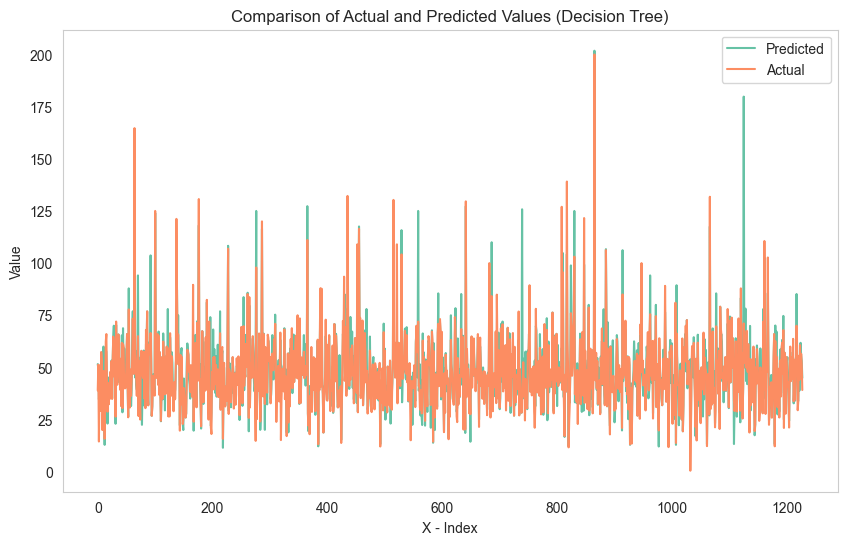

Training Random Forest...


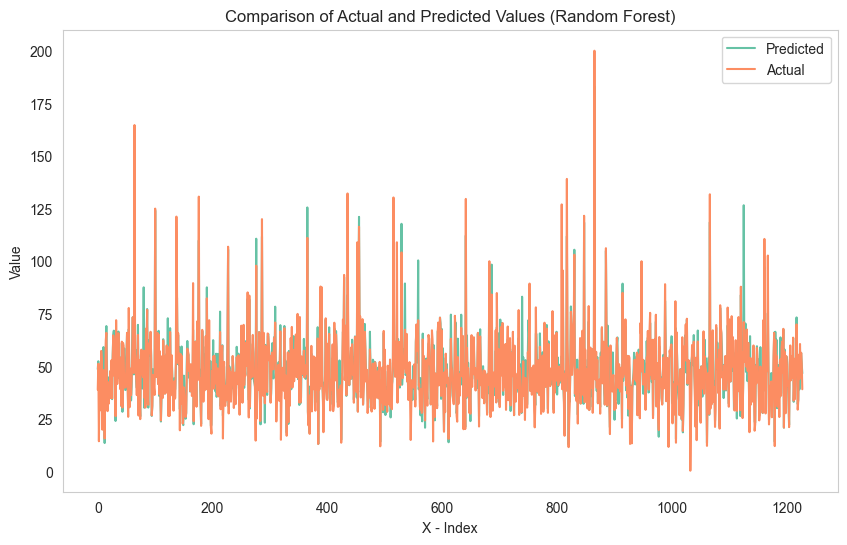

Training Gradient Boosting...


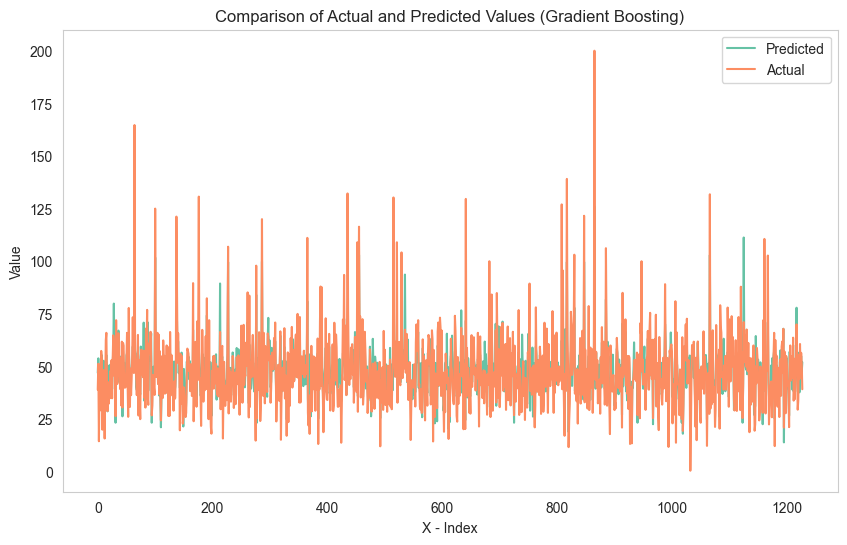

,Model,RMSE,MAE,R-squared
0,Linear Regression,16.099246,10.118726,0.191067
1,Decision Tree,9.287360,5.044335,0.730793
2,Random Forest,7.495549,4.189398,0.824649
3,Gradient Boosting,11.067353,7.699857,0.617713


In [10]:
# Initialize regression models
models = {
    'Linear Regression': LinearRegression,
    'Decision Tree': DecisionTreeRegressor,
    'Random Forest': RandomForestRegressor,
    'Gradient Boosting': GradientBoostingRegressor,
}

# Initialize a list to store the results
results = []

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    
    # Obtain metrics for the current model
    rmse, mae, r2 = get_clf_metrics(model, X_train, y_train, X_test, y_test)
    
    # Append the results to the list
    results.append([name, rmse, mae, r2])

    # Fit the model
    model_instance = model()
    model_instance.fit(X_train, y_train)

    # Make predictions
    y_pred = model_instance.predict(X_test)

    # Plot comparison of actual vs predicted values for the current model
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_pred)), y_pred, label='Predicted')
    plt.plot(range(len(y_test)), y_test, label='Actual')
    plt.xlabel('X - Index')
    plt.ylabel('Value')
    plt.title(f'Comparison of Actual and Predicted Values ({name})')
    plt.legend()
    plt.grid()
    plt.show()

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R-squared'])

results_df

**Tuning Hyperparameter**
1. Gradient Boosting is a popular and powerful machine learning algorithm for handling tabular datasets. It effectively captures nonlinear relationships between the target variable and input variables.
- In Gradient Boosting, we build a sequence of weak decision trees, called base learners. Each base learner is built based on adjusting the prediction errors of the previous tree. This process is done by optimizing the loss function, adjusting the weights of the base learners to minimize prediction errors.
- radient Boosting algorithm uses the gradient descent optimization method to adjust the weights of the base learners. This method searches for the best descent direction of the loss function in the weight space. This process iterates repeatedly, with each iteration creating a new base learner and updating their weights.
- One of the strengths of Gradient Boosting is its ability to handle complex tabular data without requiring special preprocessing. It can work with numerical and categorical variables, handling missing values and outliers effectively. Additionally, Gradient Boosting is resistant to overfitting and builds accurate prediction models.

2. XGBoost is a variant of Gradient Boosting with high performance and the ability to handle large datasets.
- Similar to Gradient Boosting, XGBoost builds a sequence of decision trees to solve prediction problems. Each tree in the sequence is built based on adjusting the prediction errors of the previous tree.
- However, XGBoost provides many enhancements and optimizations to improve performance and training speed.
- One of the notable advantages of XGBoost is its efficient handling of large datasets. It utilizes techniques such as "column block" and "row block" to maximize the computing capabilities of distributed and multithreaded systems.
- XGBoost also allows customization and adjustment of the model in many ways. You can customize the loss function and optimization method, adjust training parameters, and control overfitting by using measures such as L1 and L2 regularization.

In [11]:
# Define the objective function for Gradient Boosting
def objective_gb(trial):
    param_gb = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }

    model_gb = GradientBoostingRegressor(**param_gb)
    scores_gb = cross_val_score(model_gb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    return np.sqrt(-scores_gb.mean())

## Extreme Gradient Boosting (XGB)
def objective_xgb(trial):
    """Define the objective function"""
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 18),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 200),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0),
    }

    model_xg = xgb.XGBRegressor(**param)
    scores_xg = cross_val_score(model_xg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    return np.sqrt(-scores_xg.mean())

In [12]:
## Tunning
# Tuning for Gradient Boosting
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=100)
print('Best trial for Gradient Boosting:', study_gb.best_trial.params)

# Tuning for Extreme Gradient Boosting (XGB)
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)
print('Best trial for XGBoost:', study_xgb.best_trial.params)

Best trial for Gradient Boosting: {'learning_rate': 0.08241584540863946, 'n_estimators': 421, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.9977685435558099, 'max_features': 'sqrt'}
Best trial for XGBoost: {'max_depth': 14, 'learning_rate': 0.139135366796051, 'n_estimators': 706, 'min_child_weight': 9, 'gamma': 0.5097674531344686, 'subsample': 0.982399314156179, 'colsample_bytree': 0.8696276721565749, 'reg_alpha': 0.7442512343838723, 'reg_lambda': 0.2081302316407184}


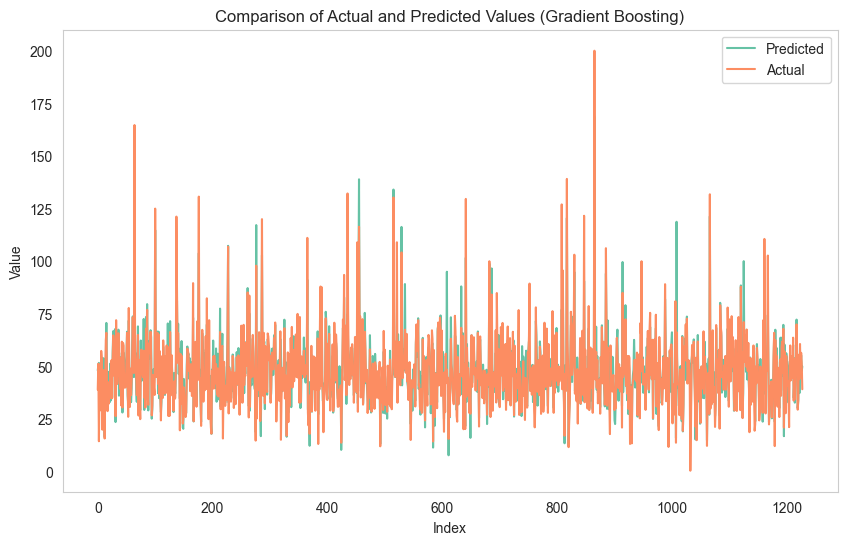

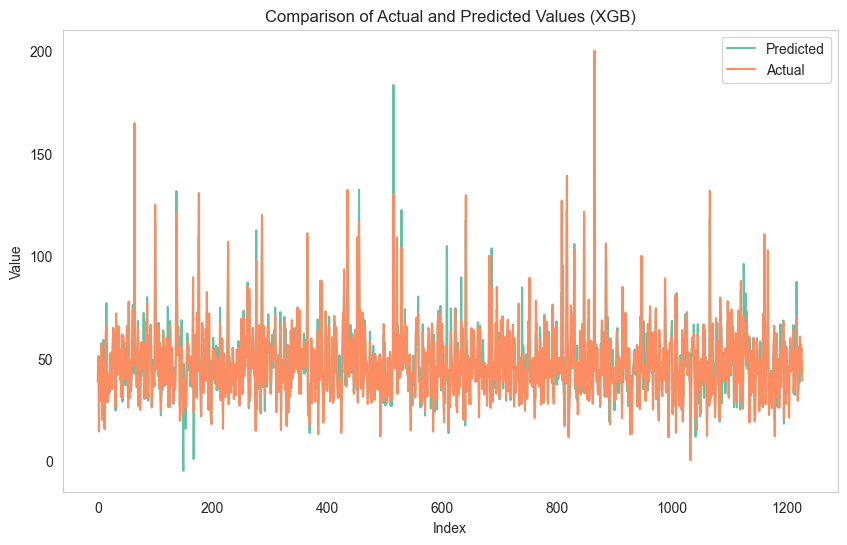

,Model,RMSE,MAE,R-squared
0,Gradient Boosting,8.035497,4.917795,0.798476
1,XGB,7.606043,4.510921,0.819441


In [14]:
# Initialize models
model1 = GradientBoostingRegressor(learning_rate=0.08241584540863946, 
                                   n_estimators=421,
                                   max_depth=10, 
                                   min_samples_split=6, 
                                   min_samples_leaf=4, 
                                   subsample=0.9977685435558099, 
                                   max_features='sqrt')
model2 =  xgb.XGBRegressor(max_depth=14, 
                           learning_rate=0.139135366796051, 
                           n_estimators=706, 
                           min_child_weight=9, 
                           gamma=0.5097674531344686, 
                           subsample=0.982399314156179, 
                           colsample_bytree=0.8696276721565749, 
                           reg_alpha=0.7442512343838723, 
                           reg_lambda=0.2081302316407184)

# Initialize lists to store the results
results_tuned = []

# Iterate over the models
for name, model in [('Gradient Boosting', model1), ('XGB', model2)]:
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the list
    results_tuned.append([name, rmse, mae, r2])

    # Plot comparison of actual vs predicted values for the current model
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_pred)), y_pred, label='Predicted')
    plt.plot(range(len(y_test)), y_test, label='Actual')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Comparison of Actual and Predicted Values ({name})')
    plt.legend()
    plt.grid()
    plt.show()

# Create a DataFrame from the results
results_tuned_df = pd.DataFrame(results_tuned, columns=['Model', 'RMSE', 'MAE', 'R-squared'])
results_tuned_df

**Stacked Generalization**
- Stacking Regression combines various regression models to produce a final prediction with higher accuracy. This method constructs a collection of regression models, called a "stack," and uses predictions from these models as input features for a final regression model, known as a "meta-regression model."
- The training process of Stacking Regression involves two stages. In the first stage, the regression models in the stack are trained on the initial training dataset. Then, in the second stage, predictions from the base models are used as input features for the meta-regression model, which is trained on the initial training dataset.
- Stacking Regression can be extended to handle multiple levels of stack and meta-regression models, creating a flexible hierarchical structure. This allows for combining predictions from different models at various levels and enhancing the predictive capability of the approach.

RMSE: 7.597862995590669
MAE: 4.374283961131441
R-squared: 0.8198291439853188


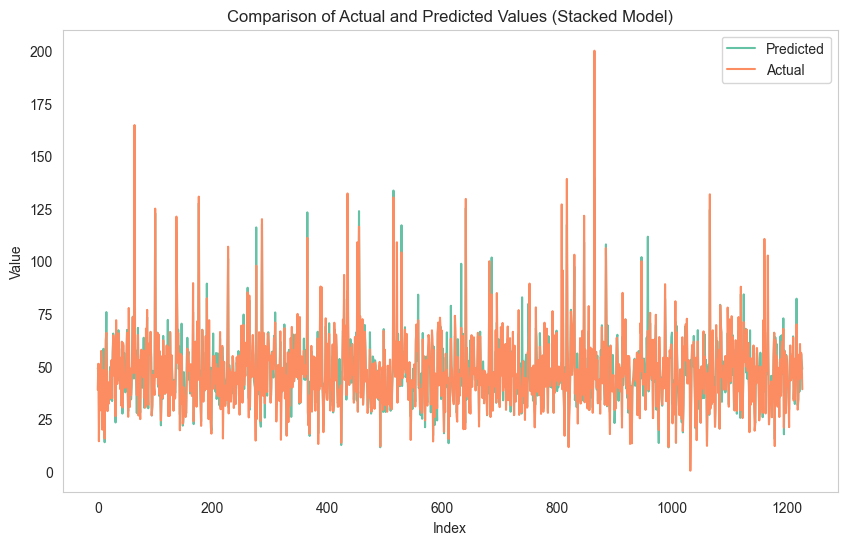

In [16]:
# Initialize base models
RF_model = RandomForestRegressor()
gboost_model = GradientBoostingRegressor(learning_rate=0.08241584540863946, 
                                        n_estimators=421,
                                        max_depth=10, 
                                        min_samples_split=6, 
                                        min_samples_leaf=4, 
                                        subsample=0.9977685435558099, 
                                        max_features='sqrt')
xgb_model = xgb.XGBRegressor(max_depth=14, 
                           learning_rate=0.139135366796051, 
                           n_estimators=706, 
                           min_child_weight=9, 
                           gamma=0.5097674531344686, 
                           subsample=0.982399314156179, 
                           colsample_bytree=0.8696276721565749, 
                           reg_alpha=0.7442512343838723, 
                           reg_lambda=0.2081302316407184)

# Initialize meta model
meta_model = xgb.XGBRegressor(verbosity=0)

# Initialize stacking regressor
stack_regressor = StackingCVRegressor(regressors=(RF_model, gboost_model, xgb_model), 
                                      meta_regressor=meta_model, 
                                      use_features_in_secondary=True)

# Fit stacking regressor
stack_model = stack_regressor.fit(X_train, y_train)

# Make predictions
stack_preds = stack_model.predict(X_test)

# Calculate metrics
rmse_stackRegressor = np.sqrt(mean_squared_error(y_test, stack_preds))
mae_stackRegressor = mean_absolute_error(y_test, stack_preds)
r2_stackRegressor = r2_score(y_test, stack_preds)

print("RMSE:", rmse_stackRegressor)
print("MAE:", mae_stackRegressor)
print("R-squared:", r2_stackRegressor)

# Plot comparison of actual vs predicted values for the stacked model
plt.figure(figsize=(10, 6))
plt.plot(range(len(stack_preds)), stack_preds, label='Predicted')
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values (Stacked Model)')
plt.legend()
plt.grid()
plt.show()

In [17]:
# Fit stacking regressor
stack_model.fit(X_train, y_train)

# Get regressors from stacking regressor
base_regressors = stack_model.regr_

# Get feature importance for each base regressor
for i, reg in enumerate(base_regressors):
    if hasattr(reg, 'feature_importances_'):
        feature_importance = reg.feature_importances_
        print(f"Feature Importance for Base Regressor {i}: {feature_importance}")
    else:
        print(f"Base Regressor {i} does not have feature importance attribute")


Feature Importance for Base Regressor 0: [3.49374971e-01 3.79818069e-02 4.27841349e-02 2.65564649e-02
 1.54474013e-01 1.01155844e-02 1.35882781e-02 1.98218763e-03
 1.67824656e-03 1.00164531e-03 2.64055253e-03 8.81970722e-03
 1.07173246e-03 4.61604546e-03 3.93161056e-03 5.98204652e-03
 3.21596834e-03 9.76013479e-03 2.25349111e-03 3.37727927e-02
 7.51585129e-04 7.69171814e-05 3.19552384e-03 6.42444165e-04
 3.12181218e-03 2.75075279e-04 1.13527624e-01 2.26922809e-02
 2.54003067e-02 1.21106077e-02 6.32895165e-03 1.91317372e-07
 7.45039913e-05 1.03644194e-03 1.76324879e-04 3.92423593e-02
 5.80408217e-06 8.19388072e-05 6.27584447e-03 2.54227107e-02
 3.33950224e-03 2.43525483e-07 4.06616544e-03 1.55567437e-05
 8.10376678e-04 9.77787434e-03 5.09529208e-04 5.44008878e-03]
Feature Importance for Base Regressor 1: [1.12336241e-01 9.52744691e-02 6.40814347e-02 1.88751317e-02
 1.34859586e-01 4.68183667e-02 5.05724979e-02 7.48340710e-03
 3.96872262e-03 1.84969663e-03 4.70660461e-03 4.73017223e-03
 3

**Result**

In [18]:
new_data = pd.DataFrame([
    {'Model': 'Stacked', 'RMSE': rmse_stackRegressor, 'MAE': mae_stackRegressor, 'R-squared': r2_stackRegressor}
])

results_df = pd.concat([results_df, new_data], ignore_index=True)
results_df

,Model,RMSE,MAE,R-squared
0,Linear Regression,16.099246,10.118726,0.191067
1,Decision Tree,9.287360,5.044335,0.730793
2,Random Forest,7.495549,4.189398,0.824649
3,Gradient Boosting,11.067353,7.699857,0.617713
4,Stacked,7.597863,4.374284,0.819829


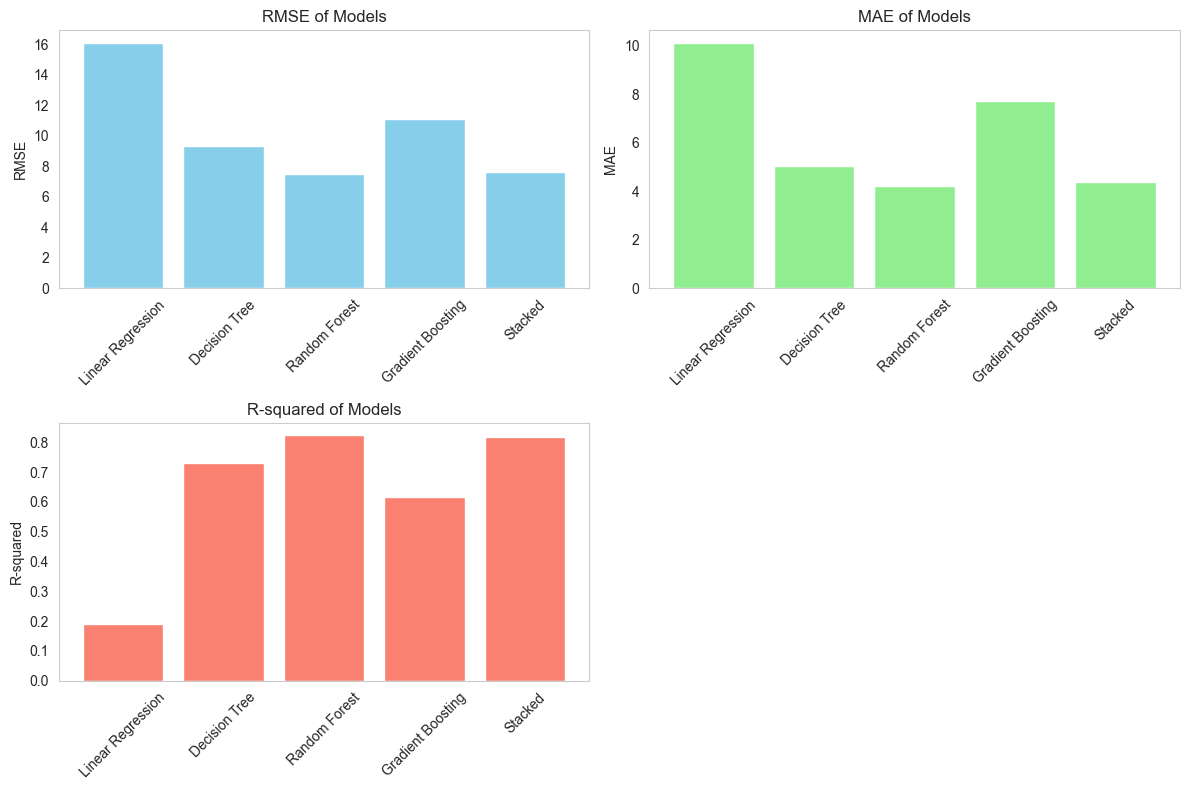

In [19]:
plt.figure(figsize=(12, 8))

# RMSE
plt.subplot(2, 2, 1)
plt.bar(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.title('RMSE of Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(False) 

# MAE
plt.subplot(2, 2, 2)
plt.bar(results_df['Model'], results_df['MAE'], color='lightgreen')
plt.title('MAE of Models')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(False) 

# R-squared
plt.subplot(2, 2, 3)
plt.bar(results_df['Model'], results_df['R-squared'], color='salmon')
plt.title('R-squared of Models')
plt.ylabel('R-squared')
plt.xticks(rotation=45)
plt.grid(False) 

plt.tight_layout()
plt.show()

**Conclusion - Basic Model**
- Random Forest and Stacked Model are the top-performing models in predicting house prices, with the lowest RMSE and MAE along with the highest R-squared. Particularly, the Stacked Model outperforms with lower RMSE and MAE compared to Random Forest.
- Although the Decision Tree model has lower RMSE and MAE compared to some other models such as Linear Regression and Gradient Boosting, its R-squared is not as high, indicating lower fit to the data.

**Compute RMSE with cross validation**

In [20]:
from sklearn.model_selection import KFold

def rmse_kfold(model, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(np.mean(rmse))

In [23]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Stacked', stack_model)
]

# List to store RMSE values
rmse_values_kfold = []

# Calculate RMSE for each model
for name, model in models:
    print(f"Calculating RMSE for {name}...")
    rmse_mean = rmse_kfold(model, 5)
    rmse_values_kfold.append({'Model': name, 'RMSE': rmse_mean})

# Create DataFrame
cross_df = pd.DataFrame(rmse_values_kfold)

# Display the results
cross_df

Calculating RMSE for Linear Regression...
Calculating RMSE for Decision Tree...
Calculating RMSE for Random Forest...
Calculating RMSE for Gradient Boosting...
Calculating RMSE for Stacked...


,Model,RMSE
0,Linear Regression,18.451269
1,Decision Tree,15.304295
2,Random Forest,10.804430
3,Gradient Boosting,13.175068
4,Stacked,11.386200


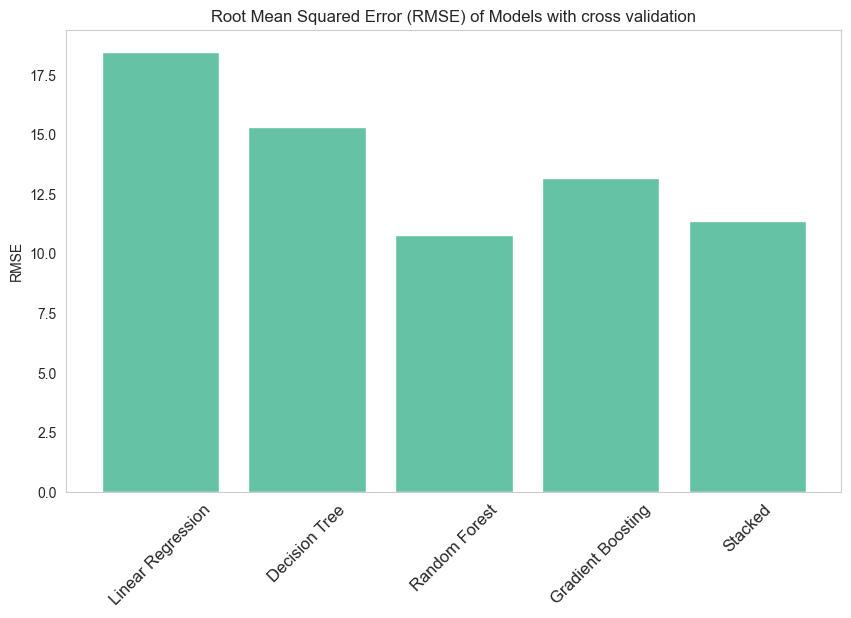

In [24]:
# RMSE with cross validation kfold = 5
plt.figure(figsize=(10, 6))
plt.bar(cross_df['Model'], cross_df['RMSE'])
plt.title('Root Mean Squared Error (RMSE) of Models with cross validation')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.xticks(fontname='Arial', fontsize=12)
plt.grid(False) 
plt.show()

- Linear Regression and Decision Tree models exhibit higher RMSE values compared to other models, indicating less accurate predictions for house prices.
- Based on the RMSE values obtained from k-fold cross-validation, the Random Forest shows the best performance in predicting house prices, followed by the Stacked Model. 